 Import data, etc. 

In [26]:
import pandas as pd
import numpy as np
import datetime 
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics, cross_validation  
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns

In [2]:
dfTest = pd.read_csv("test_results.csv")
dfUser = pd.read_csv("user_table.csv")
# Join tables 
df_raw = pd.merge(dfTest,
                  dfUser, how='left',
                  left_on=['user_id'], right_on=['user_id'])

In [19]:
print list(df_raw)
# Dummify variables 
srcDummy= pd.get_dummies(df_raw['source'])
devDummy= pd.get_dummies(df_raw['device'])
oprDummy= pd.get_dummies(df_raw['operative_system'])
# citDummy= pd.get_dummies(df_raw['city'])

df= pd.concat([df_raw, srcDummy, devDummy, oprDummy], axis=1)
print list(df)

['user_id', 'timestamp', 'source', 'device', 'operative_system', 'test', 'price', 'converted', 'city', 'country', 'lat', 'long']
['user_id', 'timestamp', 'source', 'device', 'operative_system', 'test', 'price', 'converted', 'city', 'country', 'lat', 'long', 'ads-bing', 'ads-google', 'ads-yahoo', 'ads_facebook', 'ads_other', 'direct_traffic', 'friend_referral', 'seo-bing', 'seo-google', 'seo-other', 'seo-yahoo', 'seo_facebook', 'mobile', 'web', 'android', 'iOS', 'linux', 'mac', 'other', 'windows']


In [17]:
print df_raw.head(10)
print df.head(10)

   user_id            timestamp          source  device operative_system  \
0   604839  2015-05-08 03:38:34    ads_facebook  mobile              iOS   
1   624057  2015-05-10 21:08:46      seo-google  mobile          android   
2   317970  2015-04-04 15:01:23        ads-bing  mobile          android   
3   685636  2015-05-07 07:26:01  direct_traffic  mobile              iOS   
4   820854  2015-05-24 11:04:40    ads_facebook     web              mac   
5   169971  2015-04-13 12:07:08      ads-google  mobile              iOS   
6   600150  2015-03-04 14:45:44    seo_facebook     web          windows   
7   798371  2015-03-15 08:19:29        ads-bing  mobile          android   
8   447194  2015-03-28 12:28:10    ads_facebook     web          windows   
9   431639  2015-04-24 12:42:18    ads_facebook     web          windows   

   test  price  converted          city country    lat   long  
0     0     39          0       Buffalo     USA  42.89 -78.86  
1     0     39          0     Lakev

In [4]:
# AA Testing to see if the test was well designed 
# draw random sample from non-test, find conversion rate 
# df_0=df.loc[df['test']==0]
# print df_0

# for i in range(0, 9):
# print df.groupby(['converted'])['test'].size()

In [6]:
# AB Testing 

# Find sum(converted)/sum(test) vs. test (0, 1)
summary=pd.crosstab(df_raw['converted'],df_raw['test'])
summarynorm=pd.crosstab(df_raw['converted'],df_raw['test'], normalize='columns')
print summary
print summarynorm

# Looks like less people are buying product with the test.
# Check if this difference is statistically significant using chi-squared  
chiStat = (((summarynorm.iloc[1][1]-summarynorm.iloc[1][0])**2)/summarynorm.iloc[1][0]).sum()
print chiStat

crit=stats.chi2.ppf(q=0.05,df=1)
print crit

pValue=stats.chi2.cdf(x=chiStat,df=1)
print pValue

# pValue < 0.05, difference in sales is statistically significant 
join=df.groupby(['converted']).size().reset_index(name='joinCount')


test            0       1
converted                
0          198692  112300
1            4035    1773
test              0         1
converted                    
0          0.980096  0.984457
1          0.019904  0.015543
0.000955492677494
0.00393214000002
0.024659518174


In [7]:
# Find out if there's a revenue 

# ratio of revenue w/ price increase/ default
ratio = summarynorm.iloc[1][1]*59/(summarynorm.iloc[1][0]*39)
ratio

## Finding 1: 18% increase in revenue, go ahead with $59.  

1.1813574695197979

Regression to find actionable items.
Features: city, source, device, OS, time? 

                  0         0
0             price -0.011637
1               lat -0.003951
2              long -0.000567
3          ads-bing -0.332954
4        ads-google  0.232202
5         ads-yahoo -0.160764
6      ads_facebook  0.168267
7         ads_other -0.197230
8    direct_traffic -0.380911
9   friend_referral  0.873747
10         seo-bing -0.041492
11       seo-google -0.041292
12        seo-other -0.071457
13        seo-yahoo  0.323054
14     seo_facebook -0.111780
15           mobile  0.367070
16              web -0.107680
17          android -0.223824
18              iOS  0.152656
19            linux -0.333630
20              mac  0.818389
21            other -0.421010
22          windows  0.266810
[[ -1.16370758e-02  -3.95137668e-03  -5.66558162e-04  -3.32954354e-01
    2.32202167e-01  -1.60764350e-01   1.68266773e-01  -1.97229735e-01
   -3.80911381e-01   8.73747318e-01  -4.14916012e-02  -4.12922315e-02
   -7.14570682e-02   3.23054385e-01  -1.11779687e-01   3.67070229e-01


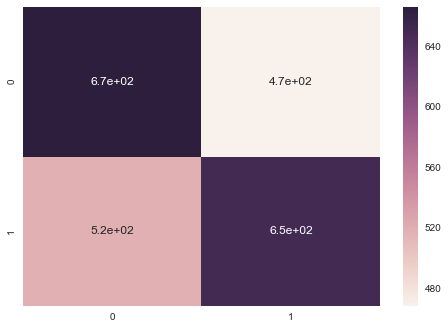

In [29]:
def train_logistic_regression(train_x, train_y):
    logistic_regression_model = LogisticRegression()
    logistic_regression_model.fit(train_x, train_y)
#     print(logistic_regression_model.coef_)
    return logistic_regression_model

def model_accuracy(trained_model, features, targets):
    accuracy_score = trained_model.score(features, targets)
    return accuracy_score

df=df.fillna(0)
features=['price', 'lat', 'long', 'ads-bing', 'ads-google', 
           'ads-yahoo', 'ads_facebook', 'ads_other', 'direct_traffic', 
          'friend_referral', 'seo-bing', 'seo-google', 'seo-other', 'seo-yahoo', 'seo_facebook', 
          'mobile', 'web', 'android', 'iOS', 'linux', 'mac', 'other', 'windows']


nsample=5700
df_majority = df[df.converted==0]
df_minority = df[df.converted==1]
df_sample = df_majority.sample(n=nsample)

df_resample = pd.concat([df_sample, df_minority])


train_x, test_x, train_y, test_y = train_test_split(df_resample[features], df_resample[['converted']], train_size=0.8)


# Training Logistic regression model
trained_logistic_regression_model = train_logistic_regression(train_x, train_y)
train_accuracy = model_accuracy(trained_logistic_regression_model, train_x, train_y)

# Feature importance 
coefficients = pd.concat([pd.DataFrame(features),pd.DataFrame(np.transpose(trained_logistic_regression_model.coef_))], axis = 1)
print coefficients
# print trained_logistic_regression_model.coef_

print train_x.values
print train_y.values

# Testing the logistic regression model
test_accuracy = model_accuracy(trained_logistic_regression_model, test_x, test_y)    
predicted = cross_validation.cross_val_predict(LogisticRegression(), train_x, train_y['converted'], cv=2)
###
# Validation 
print "Accuracy :: ", metrics.accuracy_score(train_y, predicted)
print "Report :: ", metrics.classification_report(train_y, predicted) 

test_x['prediction']=trained_logistic_regression_model.predict(test_x)
conf_matrix=confusion_matrix(test_y, test_x['prediction'])
sns.heatmap(conf_matrix, annot=True)
sns.plt.show()

## Findings
# 1. Ads on bing and yahoo may not be good investment 
# 2. Friend referral yields high conversion. Friend related promo suggested.
# 3. Mac users prefer the software. Target mac users in marketing 
# 4. Mobile users 

Find sample size nc that gives power > 0.8.
Identify date @ nc